In [1]:
import pandas as pd

In [2]:
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
merged_data = pd.merge(transactions, customers, on="CustomerID")
merged_data = pd.merge(merged_data, products, on="ProductID")

In [4]:
from datetime import datetime

merged_data['TransactionDate'] = pd.to_datetime(merged_data['TransactionDate'])
latest_date = merged_data['TransactionDate'].max()

customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'TransactionDate': lambda x: (latest_date - x.max()).days
}).reset_index()

customer_features.columns = ['CustomerID', 'TotalSpend', 'TransactionCount', 'Recency']

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['TotalSpend', 'TransactionCount', 'Recency']])

# Applying DBSCAN clustering

In [6]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust `eps` and `min_samples` based on the data
clusters = dbscan.fit_predict(scaled_features)

In [7]:
customer_features['Cluster'] = clusters

In [8]:
from sklearn.metrics import davies_bouldin_score

valid_points = customer_features[customer_features['Cluster'] != -1]
valid_scaled_features = scaled_features[valid_points.index]
valid_clusters = valid_points['Cluster']

db_index = davies_bouldin_score(valid_scaled_features, valid_clusters)
print(f"Davies-Bouldin Index: {db_index}")

Davies-Bouldin Index: 0.6452331436207528


In [9]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(valid_scaled_features, valid_clusters)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.3299999414504468


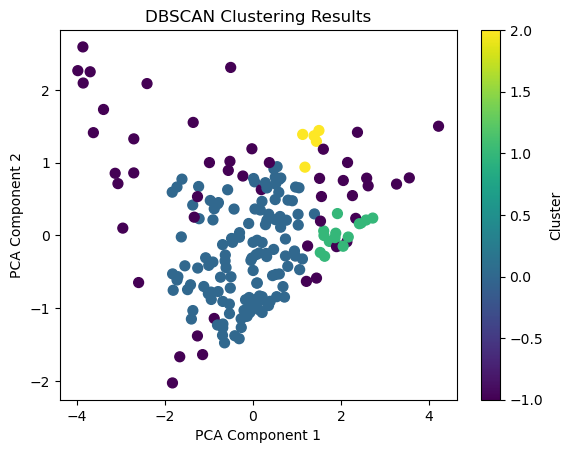

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=50)
plt.title("DBSCAN Clustering Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()

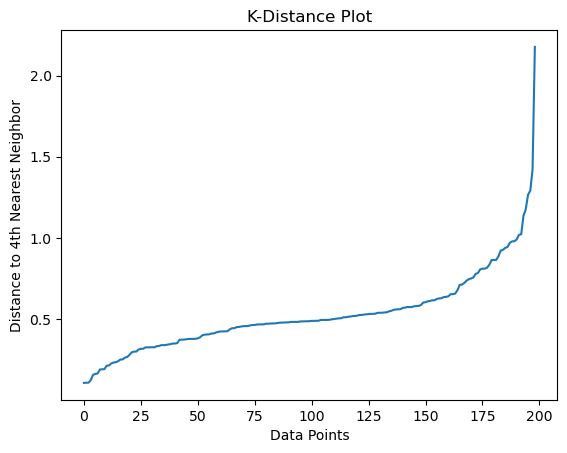

In [11]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

distances = np.sort(distances[:, 4], axis=0)
plt.plot(distances)
plt.title("K-Distance Plot")
plt.xlabel("Data Points")
plt.ylabel("Distance to 4th Nearest Neighbor")
plt.show()

In [12]:
cluster_summary = customer_features.groupby('Cluster').agg({
    'TotalSpend': ['mean', 'std'],
    'TransactionCount': ['mean', 'std'],
    'Recency': ['mean', 'std']
})
print(cluster_summary)

          TotalSpend              TransactionCount               Recency  \
                mean          std             mean       std        mean   
Cluster                                                                    
-1       3475.506042  2676.861570         5.145833  3.439381  123.604167   
 0       3093.366641  1187.699899         4.580153  1.329859   61.564885   
 1       5849.732000   745.660107         7.733333  0.593617   10.000000   
 2       6038.852000   371.113212         7.400000  0.547723  111.200000   

                     
                std  
Cluster              
-1       108.450349  
 0        42.504497  
 1        10.723805  
 2        11.627553  
